# Mean Reversion Strategy - Phase 2

Interactive workflow for developing and testing mean reversion strategies.

## Workflow:
1. Load historical data
2. Analyze universe for mean reversion characteristics
3. Generate signals using adaptive methods
4. Backtest with default parameters
5. Optimize parameters using walk-forward analysis
6. Compare strategies and visualize results

## 1. Setup & Initialization

In [1]:
# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

# Imports
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

# Matplotlib settings
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Basic imports successful!")

✓ Basic imports successful!


In [2]:
# Add src to path
project_root = Path.cwd().parent if Path.cwd().name == 'src' else Path.cwd()
sys.path.insert(0, str(project_root / 'src'))

# Load configuration from YAML
from strategy_config import ConfigLoader

config = ConfigLoader(project_root / 'config.yaml')
print("Configuration loaded from config.yaml\n")

# Import strategy modules
from strategies.mean_reversion import (
    MeanReversionSignals,
    UniverseAnalyzer,
    SignalConfig
)

from backtest.engine import (
    BacktestEngine,
    BacktestConfig,
    calculate_rolling_sharpe,
    calculate_underwater_curve
)

from backtest.optimizer import (
    ParameterOptimizer,
    OptimizationConfig,
    plot_wf_results
)

print("Strategy modules imported successfully!")

# Show key config values
print("\n" + "="*60)
print("KEY CONFIGURATION VALUES")
print("="*60)
print(f"Initial Capital: ${config.get('backtest.initial_capital'):,.0f}")
print(f"Entry Threshold: {config.get('backtest.entry_threshold')}")
print(f"Exit Threshold: {config.get('backtest.exit_threshold')}")
print(f"Commission: {config.get('backtest.commission_pct')*100:.2f}%")
print(f"Max Symbols: {config.get('data.max_symbols', 'All')}")
print(f"Hurst Threshold: {config.get('signals.hurst.threshold')}")
print(f"Optimization Method: {config.get('optimization.method')}")
print(f"\n--- Phase 2.5 Upgrades ---")
print(f"Log Returns: {config.get('backtest.use_log_returns', True)}")
print(f"Log Prices (z-score): {config.get('signals.use_log_prices', True)}")
print(f"Position Sizing: {config.get('backtest.position_size_method')}")
print(f"Kalman Filter: {config.get('signals.kalman.use_kalman', True)}")
print(f"OU Predicted Return: {config.get('signals.ou_prediction.use_predicted_return', True)}")
print(f"OU Hurdle Rate: {config.get('signals.ou_prediction.hurdle_rate', 0.005)*100:.1f}%")
if config.get('backtest.position_size_method') == 'volatility_scaled':
    print(f"Vol Target: {config.get('backtest.volatility_scaling.target_volatility')*100:.0f}%")
    print(f"Vol Lookback: {config.get('backtest.volatility_scaling.vol_lookback')} days")
elif config.get('backtest.position_size_method') == 'kelly':
    print(f"Kelly Fraction: {config.get('backtest.kelly.fraction')}")
elif config.get('backtest.position_size_method') == 'signal_proportional':
    print(f"Signal Base Size: {config.get('backtest.signal_proportional.base_size')*100:.0f}%")
    print(f"Signal Scale Factor: {config.get('backtest.signal_proportional.scale_factor')}")
print("="*60)

Configuration loaded from config.yaml

Strategy modules imported successfully!

KEY CONFIGURATION VALUES
Initial Capital: $1,000,000
Entry Threshold: 1.5
Exit Threshold: 0.8166403752061433
Commission: 0.10%
Max Symbols: None
Hurst Threshold: 0.5
Optimization Method: bayesian

--- Phase 2.5 Upgrades ---
Log Returns: True
Log Prices (z-score): True
Position Sizing: volatility_scaled
Kalman Filter: True
OU Predicted Return: True
OU Hurdle Rate: 0.5%
Vol Target: 15%
Vol Lookback: 60 days


## 2. Load Historical Data

Load the Parquet files collected in Phase 1.

In [3]:
# Data directory
data_dir = project_root / 'data' / 'historical' / 'daily'

# List available parquet files
parquet_files = list(data_dir.glob('*.parquet'))
print(f"Found {len(parquet_files)} data files")

# Load sample to inspect
if parquet_files:
    sample_df = pd.read_parquet(parquet_files[0])
    print(f"\nSample data (first file):")
    print(sample_df.head())
    print(f"\nDate range: {sample_df.index.min()} to {sample_df.index.max()}")
    print(f"Total bars: {len(sample_df)}")

Found 293 data files

Sample data (first file):
  symbol       date    open    high     low   close      volume  average  \
0   AAPL 2024-02-14  185.32  185.53  182.44  184.15  3.4582e+07  183.492   
1   AAPL 2024-02-15  183.50  184.49  181.35  183.86  4.1726e+07  182.533   
2   AAPL 2024-02-16  183.42  184.85  181.66  182.31  3.1570e+07  182.823   
3   AAPL 2024-02-20  181.77  182.43  180.00  181.56  3.2239e+07  180.944   
4   AAPL 2024-02-21  181.94  182.89  180.66  182.32  2.6528e+07  181.910   

   barCount  
0    174498  
1    204347  
2    151300  
3    164537  
4    133119  

Date range: 0 to 500
Total bars: 501


In [4]:
def load_all_data(data_dir: Path, max_symbols: int = None) -> dict:
    """
    Load all parquet files into a dictionary with datetime index
    
    Returns:
        Dict of {symbol: DataFrame}
    """
    data = {}
    files = list(data_dir.glob('*.parquet'))
    
    if max_symbols:
        files = files[:max_symbols]
    
    for file in files:
        symbol = file.stem  # Filename without extension
        try:
            df = pd.read_parquet(file)
            # Set date column as index if it exists
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'])
                df = df.set_index('date').sort_index()
            data[symbol] = df
        except Exception as e:
            print(f"Error loading {symbol}: {e}")
    
    return data

# Load data using config
print("Loading data...")
max_symbols = config.get('data.max_symbols')
all_data = load_all_data(data_dir, max_symbols=max_symbols)
print(f"Loaded {len(all_data)} symbols")

# Extract price and volume series (now with datetime index)
price_data = {symbol: df['close'] for symbol, df in all_data.items()}
volume_data = {symbol: df['volume'] for symbol, df in all_data.items()}

# Verify datetime index
sample_key = list(price_data.keys())[0]
print(f"\nIndex type: {type(price_data[sample_key].index).__name__}")
print(f"Date range: {price_data[sample_key].index.min()} to {price_data[sample_key].index.max()}")
print("Data loaded successfully!")

Loading data...
Loaded 293 symbols

Index type: DatetimeIndex
Date range: 2024-02-14 00:00:00 to 2026-02-12 00:00:00
Data loaded successfully!


In [5]:
# Initialize analyzer with config
signal_config = config.to_signal_config()
analyzer = UniverseAnalyzer(signal_config)

# Analyze universe
min_history = config.get("data.min_history", 100)
print(f"Analyzing universe for mean reversion (min history: {min_history})...")
print("This may take a few minutes...\n")

analysis_df = analyzer.analyze_universe(price_data, min_history=min_history)

print(f"Analysis complete!\n")
print(analysis_df.head(20))


Analyzing universe for mean reversion (min history: 100)...
This may take a few minutes...



Analysis complete!

    symbol  is_mean_reverting   hurst  half_life  adf_pvalue  data_points
36    DNOW               True  0.2097    11.5795      0.0722          501
225   SPGI               True  0.2528    46.7099      0.2196          501
208   BBWI               True  0.2667    84.9505      0.5573          501
214    LIN               True  0.3019    21.0910      0.0901          501
200   BKNG               True  0.3130    91.2895      0.5322          501
94    KTOS               True  0.3162        NaN      0.8400          501
247   HURN               True  0.3225    96.7746      0.5749          501
126     JD               True  0.3229    33.6516      0.1373          501
205   LUMN               True  0.3261    73.9186      0.4110          501
264     MO               True  0.3269   114.5059      0.6197          501
213   CTSH               True  0.3290    33.9022      0.0393          501
76     RBC               True  0.3305        NaN      0.9965          501
172    UNP        

In [6]:
# Summary statistics
print("Mean Reversion Analysis Summary:")
print(f"Total stocks analyzed: {len(analysis_df)}")
print(f"Mean-reverting stocks: {analysis_df['is_mean_reverting'].sum()}")
print(f"Percentage: {analysis_df['is_mean_reverting'].mean()*100:.1f}%")
print(f"\nHurst exponent statistics:")
print(analysis_df['hurst'].describe())
print(f"\nHalf-life statistics (days):")
print(analysis_df['half_life'].describe())

Mean Reversion Analysis Summary:
Total stocks analyzed: 293
Mean-reverting stocks: 285
Percentage: 97.3%

Hurst exponent statistics:
count    293.0000
mean       0.4317
std        0.0574
min        0.2097
25%        0.3948
50%        0.4336
75%        0.4694
max        0.6303
Name: hurst, dtype: float64

Half-life statistics (days):
count    237.0000
mean      79.8490
std       49.9634
min       11.5795
25%       44.0058
50%       69.3653
75%      100.1310
max      244.8013
Name: half_life, dtype: float64


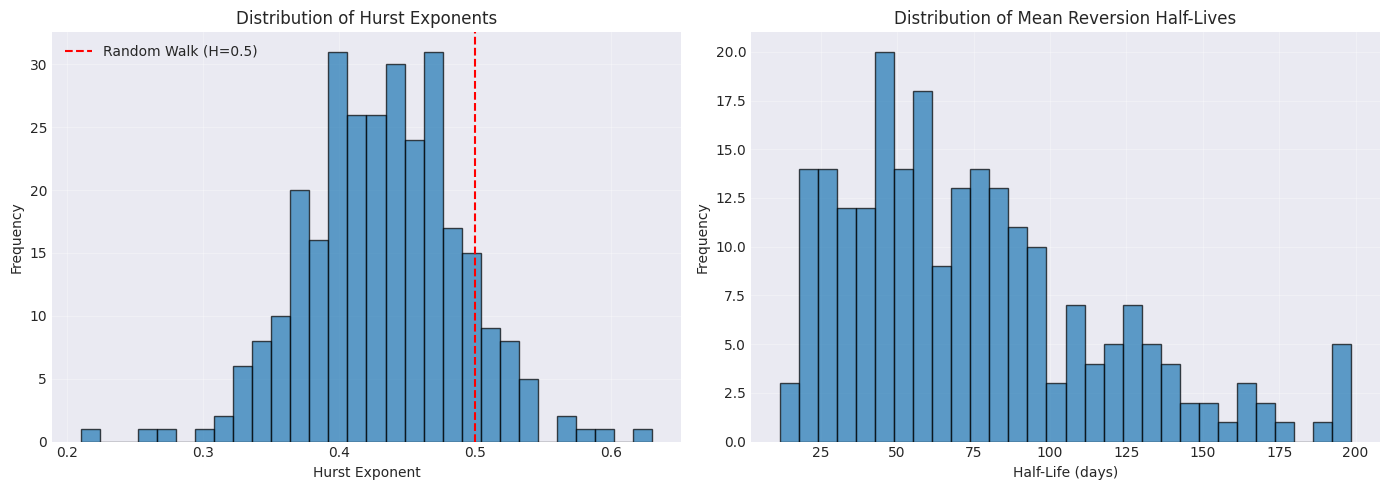

In [7]:
# Visualize Hurst distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hurst histogram
axes[0].hist(analysis_df['hurst'].dropna(), bins=30, alpha=0.7, edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Random Walk (H=0.5)')
axes[0].set_xlabel('Hurst Exponent')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Hurst Exponents')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Half-life histogram
half_lives = analysis_df['half_life'].dropna()
axes[1].hist(half_lives[half_lives < 200], bins=30, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Half-Life (days)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Mean Reversion Half-Lives')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Filter to mean-reverting stocks only
mean_reverting_symbols = analysis_df[analysis_df['is_mean_reverting']]['symbol'].tolist()
print(f"Trading universe: {len(mean_reverting_symbols)} mean-reverting stocks")
print(f"\nTop 10 most mean-reverting (lowest Hurst):")
print(analysis_df.head(10)[['symbol', 'hurst', 'half_life']])

Trading universe: 285 mean-reverting stocks

Top 10 most mean-reverting (lowest Hurst):
    symbol   hurst  half_life
36    DNOW  0.2097    11.5795
225   SPGI  0.2528    46.7099
208   BBWI  0.2667    84.9505
214    LIN  0.3019    21.0910
200   BKNG  0.3130    91.2895
94    KTOS  0.3162        NaN
247   HURN  0.3225    96.7746
126     JD  0.3229    33.6516
205   LUMN  0.3261    73.9186
264     MO  0.3269   114.5059


## 4. Generate Signals

Generate mean reversion signals for the filtered universe.

In [9]:
# Initialize signal generator with config
signal_config = config.to_signal_config()
signal_gen = MeanReversionSignals(signal_config)

# Get composite weights from config
composite_weights = config.get_composite_weights()

# Generate signals for ALL mean-reverting stocks
show_progress = config.get('logging.show_progress', True)
progress_interval = config.get('logging.progress_interval', 50)

print("Generating signals for all mean-reverting stocks...")
print(f"Using weights: {composite_weights}")
print(f"Kalman Filter: {'ON' if signal_config.use_kalman else 'OFF'}")
print(f"OU Prediction Gate: {'ON' if signal_config.use_predicted_return else 'OFF'}")
print(f"Log Prices: {'ON' if signal_config.use_log_prices else 'OFF'}\n")

all_signals = {}
all_individual_signals = {}

for i, symbol in enumerate(mean_reverting_symbols):
    if symbol in price_data and symbol in volume_data:
        prices = price_data[symbol]
        volumes = volume_data[symbol]
        
        composite, individual = signal_gen.generate_composite_signal(
            prices, volumes, weights=composite_weights
        )
        all_signals[symbol] = composite
        all_individual_signals[symbol] = individual

    if show_progress and (i + 1) % progress_interval == 0:
        print(f"  Processed {i + 1}/{len(mean_reverting_symbols)} symbols...")

print(f"\nGenerated signals for {len(all_signals)} symbols")

# Show signal info
sample_sym = list(all_signals.keys())[0]
sample_sig = all_signals[sample_sym]
sample_ind = all_individual_signals[sample_sym]
entry_threshold = config.get('backtest.entry_threshold', 2.0)
print(f"\nSample signal stats ({sample_sym}):")
print(f"  Range: [{sample_sig.min():.2f}, {sample_sig.max():.2f}]")
print(f"  |signal| > {entry_threshold}: {(sample_sig.abs() > entry_threshold).sum()} days")
print(f"  |signal| > {entry_threshold*0.75}: {(sample_sig.abs() > entry_threshold*0.75).sum()} days")

# Show available signal components
print(f"\n  Signal components: {list(sample_ind.keys())}")
if 'expected_return' in sample_ind:
    exp_ret = sample_ind['expected_return']
    hurdle = config.get('signals.ou_prediction.hurdle_rate', 0.005)
    gated_pct = (exp_ret.abs() < hurdle).sum() / len(exp_ret) * 100
    print(f"  OU hurdle gate filters out {gated_pct:.1f}% of signals")

Generating signals for all mean-reverting stocks...
Using weights: {'bollinger': 0.0, 'rsi_divergence': 0.75, 'rsi_level': 0.0}
Kalman Filter: ON
OU Prediction Gate: ON
Log Prices: ON

  Processed 50/285 symbols...
  Processed 100/285 symbols...
  Processed 150/285 symbols...
  Processed 200/285 symbols...
  Processed 250/285 symbols...

Generated signals for 285 symbols

Sample signal stats (DNOW):
  Range: [-3.98, 3.99]
  |signal| > 1.5: 5 days
  |signal| > 1.125: 7 days

  Signal components: ['kalman_mean', 'kalman_std', 'zscore', 'expected_return', 'time_to_reversion', 'bollinger', 'rsi_divergence', 'rsi_level']
  OU hurdle gate filters out 16.0% of signals


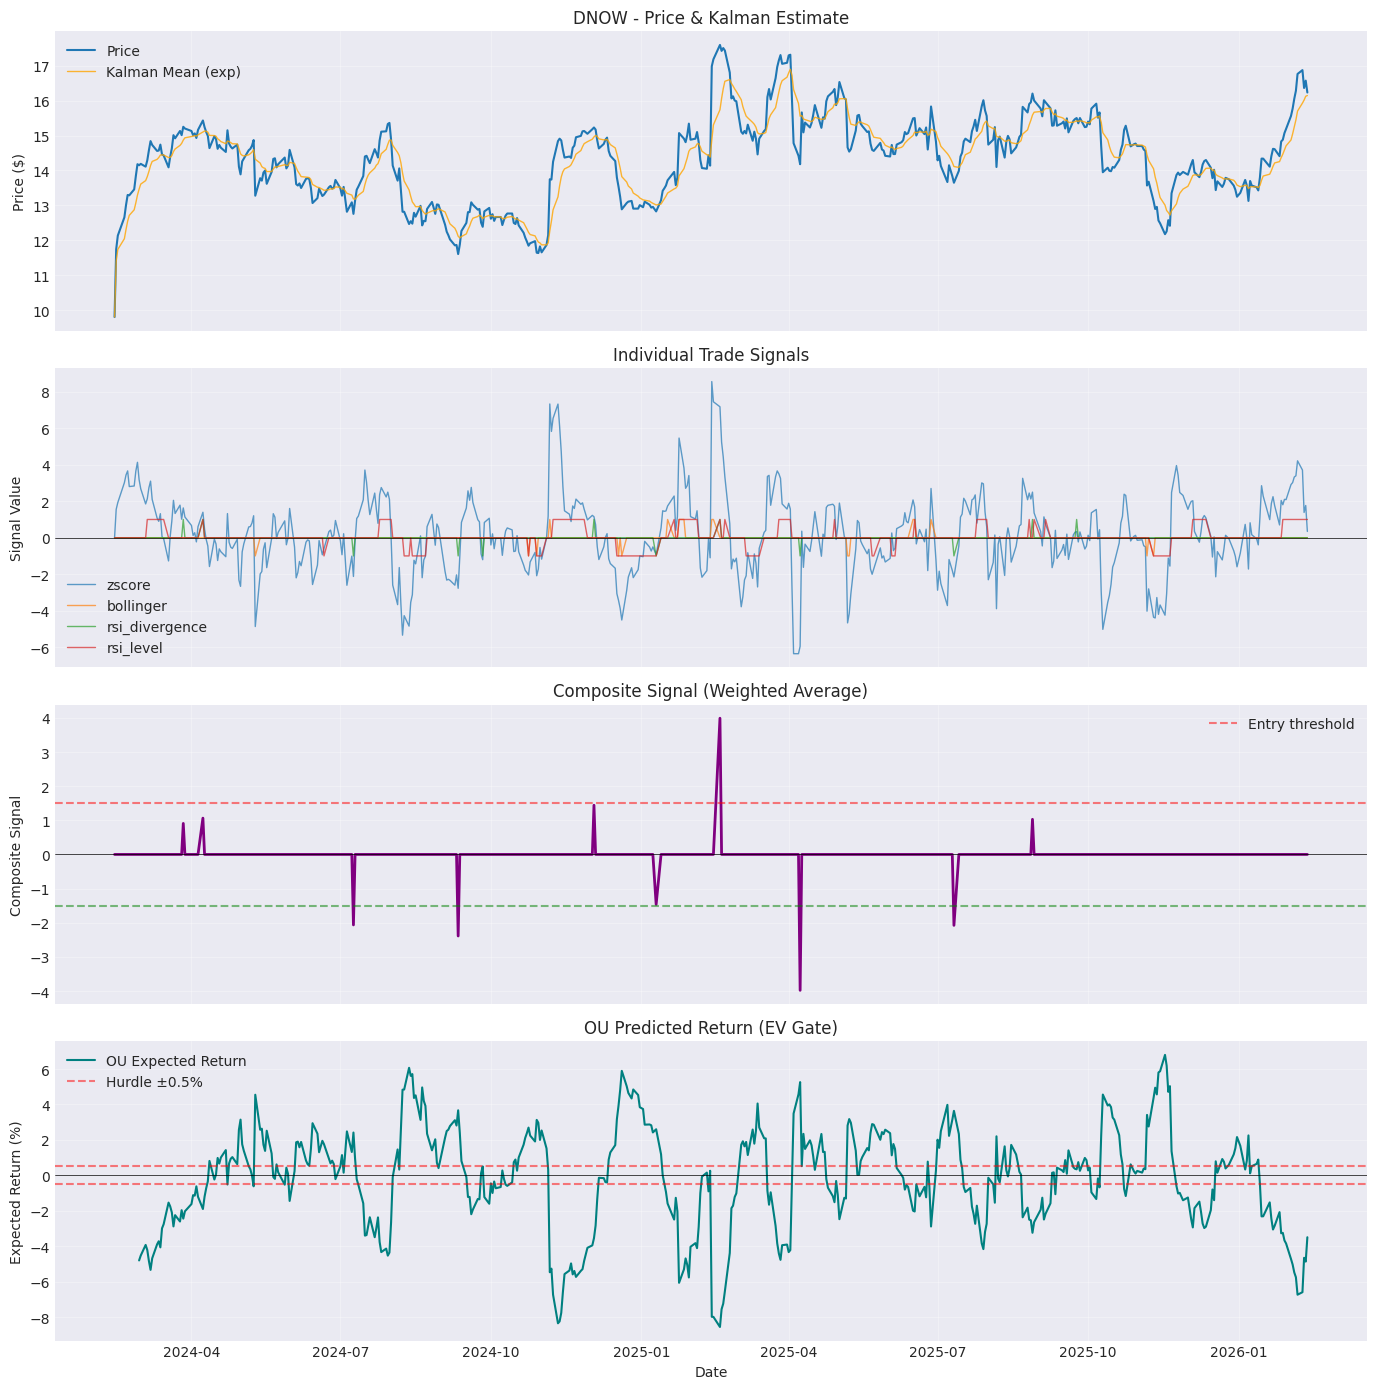

In [10]:
# Visualize signals for a sample stock
sample_symbol = mean_reverting_symbols[0]
sample_price = price_data[sample_symbol]
sample_signal = all_signals[sample_symbol]
sample_individual = all_individual_signals[sample_symbol]

# Separate trade signals from diagnostic signals
trade_signal_keys = ['zscore', 'bollinger', 'rsi_divergence', 'rsi_level']
diagnostic_keys = ['kalman_mean', 'kalman_std', 'expected_return', 'time_to_reversion']

has_diagnostics = any(k in sample_individual for k in diagnostic_keys)
n_rows = 4 if has_diagnostics else 3

fig, axes = plt.subplots(n_rows, 1, figsize=(14, 3.5 * n_rows), sharex=True)

# Price + Kalman mean overlay
axes[0].plot(sample_price.index, sample_price, linewidth=1.5, label='Price')
if 'kalman_mean' in sample_individual:
    kalman_mean = sample_individual['kalman_mean']
    # Kalman mean is in log space if use_log_prices; convert back
    use_log = config.get('signals.use_log_prices', True)
    if use_log:
        axes[0].plot(kalman_mean.index, np.exp(kalman_mean), linewidth=1, color='orange',
                     alpha=0.8, label='Kalman Mean (exp)')
    else:
        axes[0].plot(kalman_mean.index, kalman_mean, linewidth=1, color='orange',
                     alpha=0.8, label='Kalman Mean')
axes[0].set_ylabel('Price ($)')
axes[0].set_title(f'{sample_symbol} - Price & Kalman Estimate')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Individual trade signals
for name in trade_signal_keys:
    if name in sample_individual:
        signal = sample_individual[name]
        axes[1].plot(signal.index, signal, label=name, alpha=0.7, linewidth=1)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_ylabel('Signal Value')
axes[1].set_title('Individual Trade Signals')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Composite signal
axes[2].plot(sample_signal.index, sample_signal, color='purple', linewidth=2)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
entry_th = config.get('backtest.entry_threshold', 2.0)
axes[2].axhline(y=entry_th, color='red', linestyle='--', alpha=0.5, label='Entry threshold')
axes[2].axhline(y=-entry_th, color='green', linestyle='--', alpha=0.5)
axes[2].set_ylabel('Composite Signal')
axes[2].set_title('Composite Signal (Weighted Average)')
axes[2].legend()
axes[2].grid(alpha=0.3)

# OU Expected Return (if available)
if has_diagnostics and n_rows == 4:
    if 'expected_return' in sample_individual:
        exp_ret = sample_individual['expected_return']
        hurdle = config.get('signals.ou_prediction.hurdle_rate', 0.005)
        axes[3].plot(exp_ret.index, exp_ret * 100, color='teal', linewidth=1.5, label='OU Expected Return')
        axes[3].axhline(y=hurdle * 100, color='red', linestyle='--', alpha=0.5, label=f'Hurdle ±{hurdle*100:.1f}%')
        axes[3].axhline(y=-hurdle * 100, color='red', linestyle='--', alpha=0.5)
        axes[3].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        axes[3].set_ylabel('Expected Return (%)')
        axes[3].set_title('OU Predicted Return (EV Gate)')
        axes[3].legend()
        axes[3].grid(alpha=0.3)
    axes[3].set_xlabel('Date')
else:
    axes[2].set_xlabel('Date')

plt.tight_layout()
plt.show()

## 5. Backtest with Default Parameters

Run initial backtest to establish baseline performance.

In [11]:
# Convert to DataFrames for backtesting
price_df = pd.DataFrame(price_data)
signal_df = pd.DataFrame(all_signals)
volume_df = pd.DataFrame(volume_data)

# Create z-score DataFrame for exit decisions (used in gated mode)
# In gated mode, entries use composite signal but exits use raw z-score
# so positions exit when price reverts to mean, not when divergence disappears
zscore_df = pd.DataFrame({
    symbol: signals['zscore']
    for symbol, signals in all_individual_signals.items()
    if 'zscore' in signals
})

# Align data (same dates)
common_index = price_df.index.intersection(signal_df.index)
price_df = price_df.loc[common_index]
signal_df = signal_df.loc[common_index]
volume_df = volume_df.loc[common_index]
zscore_df = zscore_df.loc[common_index]

print(f"Backtest data prepared:")
print(f"  Date range: {common_index.min()} to {common_index.max()}")
print(f"  Trading days: {len(common_index)}")
print(f"  Symbols: {len(signal_df.columns)}")
print(f"  Exit signal (z-score) columns: {len(zscore_df.columns)}")

Backtest data prepared:
  Date range: 2024-02-13 00:00:00 to 2026-02-12 00:00:00
  Trading days: 502
  Symbols: 285
  Exit signal (z-score) columns: 285


In [12]:
# Run backtest with config
print("Running backtest...\n")

bt_config = config.to_backtest_config()

engine = BacktestEngine(bt_config)
results = engine.run_backtest(price_df, signal_df, volume_df, exit_signal_data=zscore_df)

print("Backtest complete!\n")
print("Performance Summary:")
print("="*50)
for key, value in results.summary().items():
    print(f"{key:25s}: {value}")

# Additional sizing info
print(f"\n--- Position Sizing ---")
print(f"Method: {bt_config.position_size_method}")
if bt_config.position_size_method == 'volatility_scaled':
    print(f"Target Vol: {bt_config.vol_target*100:.0f}%  Lookback: {bt_config.vol_lookback}d")
    print(f"Size Range: [{bt_config.vol_min_size*100:.0f}%, {bt_config.vol_max_size*100:.0f}%]")
elif bt_config.position_size_method == 'kelly':
    print(f"Kelly Fraction: {bt_config.kelly_fraction:.1%}  Lookback: {bt_config.kelly_lookback}d")

# Phase B.1-B.3 info
print(f"\n--- Phase B Features ---")
print(f"Signal Mode: {config.get('signals.signal_mode', 'gated')}")
print(f"Gate Signal: {config.get('signals.gate_signal', 'rsi_divergence')}")
print(f"Dynamic Short Filter: {config.get('signals.dynamic_short_filter.enabled', True)}")
print(f"Trailing Stop: {bt_config.use_trailing_stop} (trail={bt_config.trailing_stop_pct:.0%}, activate={bt_config.trailing_stop_activation:.0%})")
print(f"Time Decay Exit: {bt_config.use_time_decay_exit} (after {bt_config.time_decay_days}d, threshold={bt_config.time_decay_threshold:.0%})")

Running backtest...

Backtest complete!

Performance Summary:
Total Return             : 3965.96%
Annualized Return        : 542.37%
Sharpe Ratio             : 11.96
Sortino Ratio            : 59.40
Calmar Ratio             : 569.32
Max Drawdown             : 0.95%
Max DD Duration          : 3 days
Total Trades             : 1037
Win Rate                 : 99.32%
Profit Factor            : 1239.43
EV Per Trade             : 3.634%
EV Long                  : 3.603%
EV Short                 : 3.689%
Avg Win                  : 3.66%
Avg Loss                 : -0.77%
Avg Holding              : 3.2 days
Avg Exposure             : 50.00%
Max Positions            : 10
Total Commission         : $3,064,401.63

--- Position Sizing ---
Method: volatility_scaled
Target Vol: 15%  Lookback: 60d
Size Range: [2%, 10%]

--- Phase B Features ---
Signal Mode: gated
Gate Signal: rsi_divergence
Dynamic Short Filter: True
Trailing Stop: True (trail=5%, activate=2%)
Time Decay Exit: True (after 10d, thresho

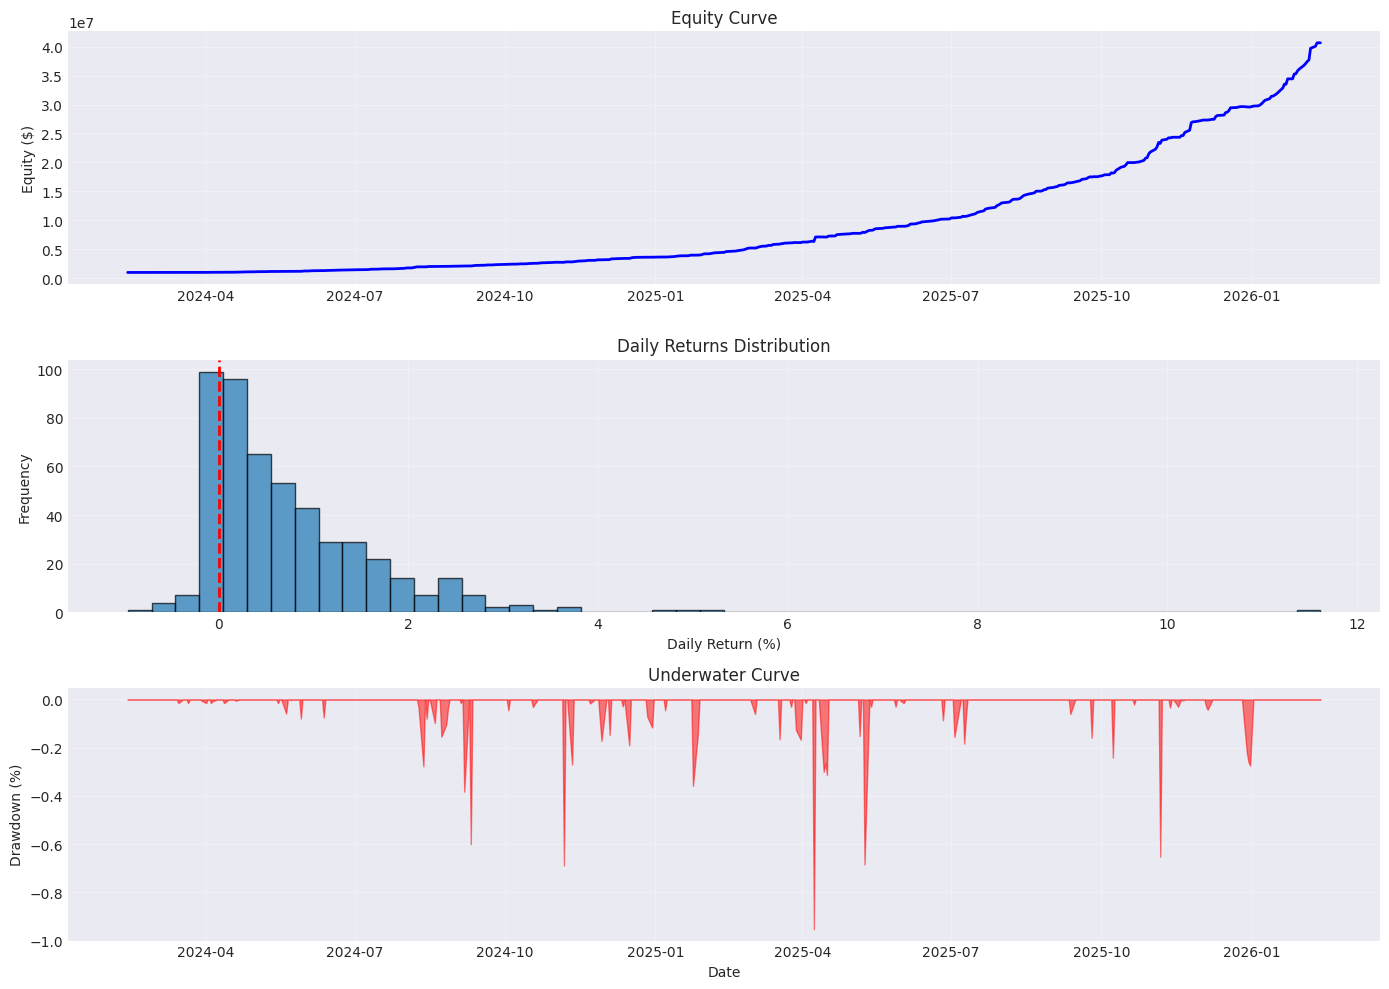

In [13]:
# Visualize backtest results
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Equity curve
axes[0].plot(results.equity_curve, linewidth=2, color='blue')
axes[0].set_ylabel('Equity ($)')
axes[0].set_title('Equity Curve')
axes[0].grid(alpha=0.3)

# Returns distribution
axes[1].hist(results.returns * 100, bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Daily Return (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Daily Returns Distribution')
axes[1].grid(alpha=0.3)

# Drawdown
drawdown = calculate_underwater_curve(results.equity_curve)
axes[2].fill_between(drawdown.index, 0, drawdown * 100, alpha=0.5, color='red')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Drawdown (%)')
axes[2].set_title('Underwater Curve')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Analyze trades
if results.trades:
    trades_df = pd.DataFrame([
        {
            'symbol': t.symbol,
            'entry_date': t.entry_date,
            'exit_date': t.exit_date,
            'side': t.side,
            'pnl_pct': t.pnl_pct * 100,
            'holding_days': t.holding_days,
            'exit_reason': t.exit_reason
        }
        for t in results.trades
    ])
    
    print("\nTrade Analysis:")
    print(f"Total trades: {len(trades_df)}")
    print(f"\nBy side:")
    print(trades_df['side'].value_counts())
    print(f"\nBy exit reason:")
    print(trades_df['exit_reason'].value_counts())
    print(f"\nTop 10 trades:")
    print(trades_df.nlargest(10, 'pnl_pct')[['symbol', 'side', 'pnl_pct', 'holding_days', 'exit_reason']])


Trade Analysis:
Total trades: 1037

By side:
side
long     660
short    377
Name: count, dtype: int64

By exit reason:
exit_reason
signal           1003
take_profit        18
time_decay          8
trailing_stop       8
Name: count, dtype: int64

Top 10 trades:
     symbol   side  pnl_pct  holding_days  exit_reason
928     ANF   long  37.1837             1  take_profit
195    FTNT   long  25.9109             2  take_profit
556    AFRM   long  23.5802             5  take_profit
602    MATX   long  22.0378             6  take_profit
1012   SANM  short  21.2893             1  take_profit
1035   DDOG   long  21.1612             5  take_profit
632    LULU  short  20.5911             2  take_profit
1027   IESC   long  19.5471             7  take_profit
725    CVLT   long  17.9312             1  take_profit
559    IESC   long  17.7884             5  take_profit


## 6. Parameter Optimization

Use walk-forward analysis to find optimal parameters.

In [15]:
# Configure optimization from config
opt_config = config.to_optimization_config()

# Pass base backtest config so optimizer inherits sizing/log-return settings
optimizer = ParameterOptimizer(opt_config, base_backtest_config=bt_config)

print("Optimization configuration:")
print(f"  Method: {opt_config.method}")
print(f"  Trials: {opt_config.n_trials}  |  Parallel jobs: {opt_config.n_jobs}")
print(f"  Train period: {opt_config.train_period_days} days")
print(f"  Test period: {opt_config.test_period_days} days")
print(f"  Step size: {opt_config.step_days} days")
print(f"  Objective: {opt_config.objective_metric}")
if opt_config.method == 'bayesian':
    print(f"  Bayesian ranges:")
    print(f"    entry_threshold: {list(opt_config.bayesian_entry_range)}")
    print(f"    exit_threshold: {list(opt_config.bayesian_exit_range)}")
    print(f"    stop_loss: {opt_config.bayesian_stop_loss_choices}")
    print(f"    take_profit: {opt_config.bayesian_take_profit_choices}")
    print(f"    max_holding: {opt_config.bayesian_max_holding_choices}")
else:
    print(f"  Grid ranges:")
    print(f"    entry_threshold: {opt_config.entry_threshold_range}")
    print(f"    exit_threshold: {opt_config.exit_threshold_range}")
    print(f"    stop_loss: {opt_config.stop_loss_range}")
    print(f"    take_profit: {opt_config.take_profit_range}")
print(f"\n  Base sizing config inherited:")
print(f"    position_size_method: {bt_config.position_size_method}")
print(f"    use_log_returns: {bt_config.use_log_returns}")

Optimization configuration:
  Method: bayesian
  Trials: 50  |  Parallel jobs: -1
  Train period: 252 days
  Test period: 126 days
  Step size: 63 days
  Objective: sharpe_ratio
  Bayesian ranges:
    entry_threshold: [1.0, 4.0]
    exit_threshold: [0.1, 1.5]
    stop_loss: [None, 0.05, 0.1, 0.15]
    take_profit: [None, 0.1, 0.15, 0.2]
    max_holding: [None, 10, 20, 30]

  Base sizing config inherited:
    position_size_method: volatility_scaled
    use_log_returns: True


In [16]:
# Create signal generator function for optimizer
def signal_generator_fn(params):
    """Generate signals (independent of backtest params)"""
    return signal_df

# Run optimization
print("Running walk-forward optimization...")
print("This may take several minutes...\n")

opt_results = optimizer.walk_forward_optimization(
    price_df,
    signal_generator_fn,
    volume_df,
    exit_signal_data=zscore_df
)

print("\n" + "="*50)
print("Optimization complete!")
print("="*50)
print("\nSummary:")
for key, value in opt_results.summary().items():
    print(f"{key:25s}: {value}")

Running walk-forward optimization...
This may take several minutes...

Running walk-forward optimization: 2 periods

Period 1/2
  Train: 2024-02-13 to 2025-02-13
  Test:  2025-02-14 to 2025-08-15
  Bayesian optimization: 50 trials, n_jobs=-1


  0%|          | 0/50 [00:00<?, ?it/s]

  Completed in 63.4s (1.27s/trial)
  Best params: {'entry_threshold': 1.0020172860555179, 'exit_threshold': 0.1663260075199738, 'stop_loss_pct': 0.15, 'take_profit_pct': None, 'max_holding_days': 20}
  Train metric: 16.413
  Test metric: 13.004

Period 2/2
  Train: 2024-05-14 to 2025-05-15
  Test:  2025-05-16 to 2025-11-13
  Bayesian optimization: 50 trials, n_jobs=-1


  0%|          | 0/50 [00:00<?, ?it/s]

  Completed in 69.7s (1.39s/trial)
  Best params: {'entry_threshold': 1.0003748455206583, 'exit_threshold': 0.11727891447847981, 'stop_loss_pct': 0.15, 'take_profit_pct': 0.2, 'max_holding_days': 20}
  Train metric: 14.094
  Test metric: 19.811

Optimization complete!

Summary:
Num Periods              : 2
Avg Train Metric         : 15.254
Avg Test Metric          : 16.408
Stability Score          : 0.828
Combined Test Return     : 1389.22%
Combined Test Sharpe     : 15.26
Combined Test Max DD     : 0.93%


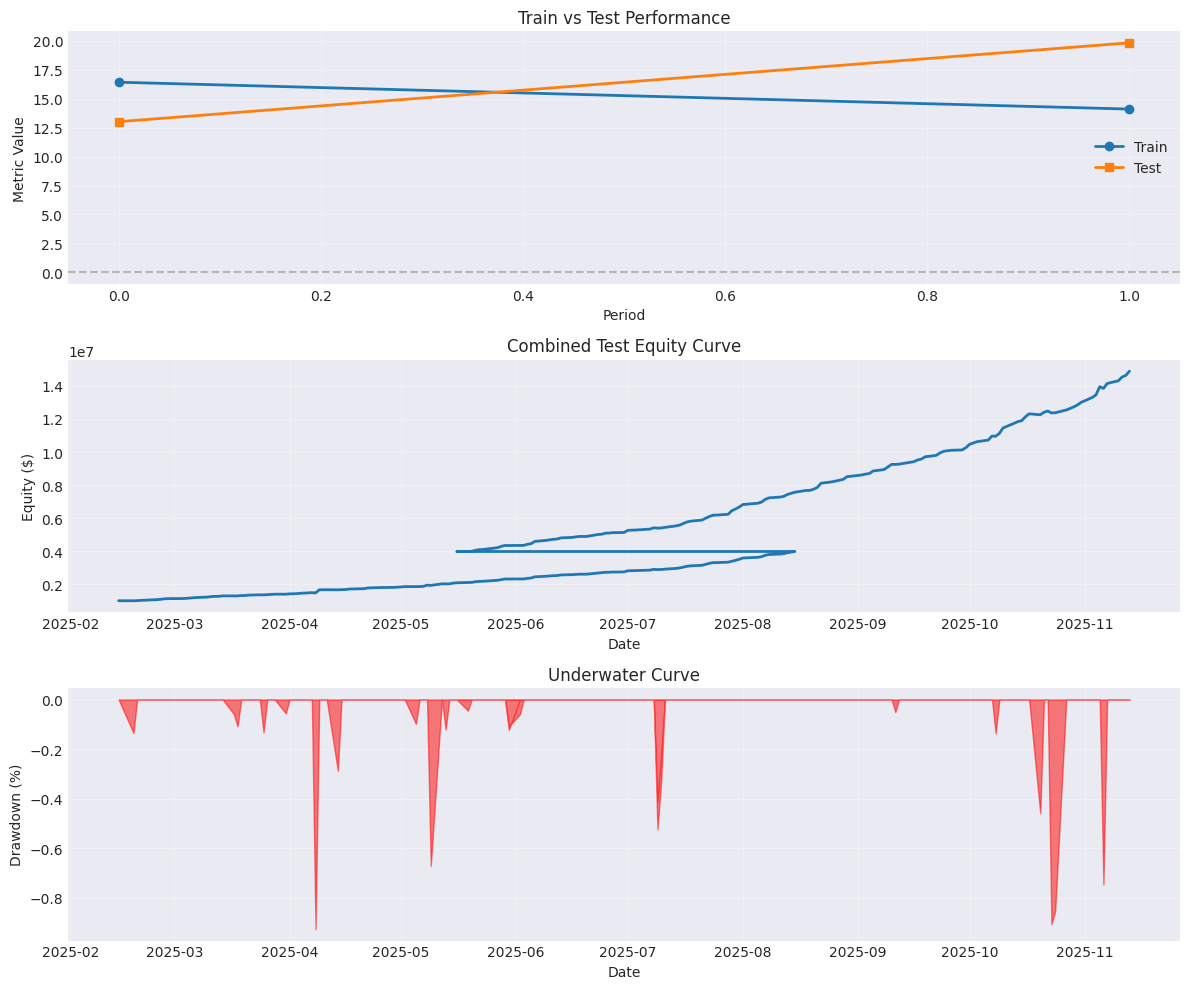

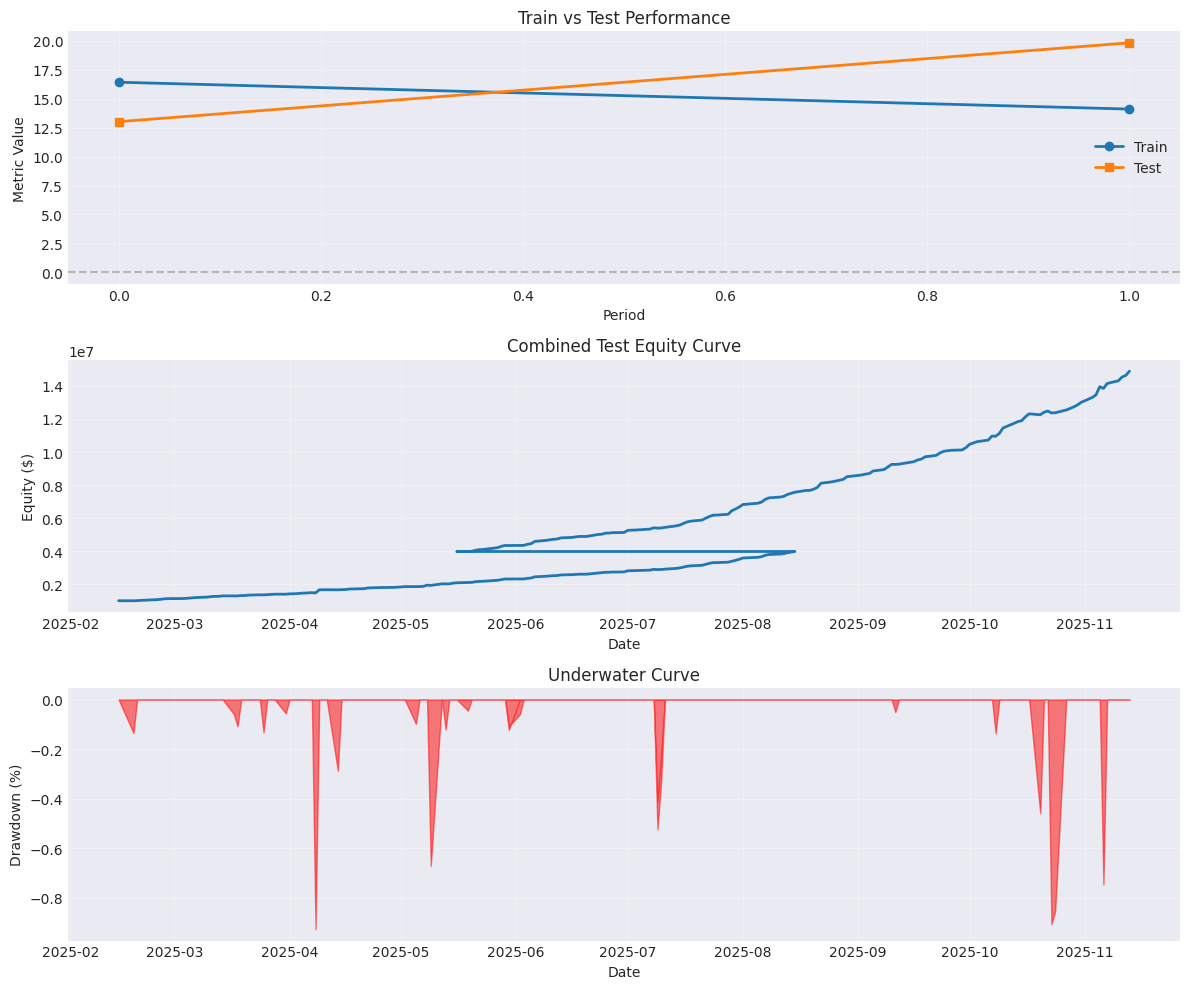

In [17]:
# Plot optimization results
plot_wf_results(opt_results)

In [18]:
# Parameter stability analysis
print("\nParameter Frequency (across all periods):")
print("="*50)
for param, count in sorted(opt_results.best_params_frequency.items(), key=lambda x: x[1], reverse=True):
    print(f"{param:30s}: {count} times")


Parameter Frequency (across all periods):
stop_loss_pct=0.15            : 2 times
max_holding_days=20           : 2 times
entry_threshold=1.0020172860555179: 1 times
exit_threshold=0.1663260075199738: 1 times
take_profit_pct=None          : 1 times
entry_threshold=1.0003748455206583: 1 times
exit_threshold=0.11727891447847981: 1 times
take_profit_pct=0.2           : 1 times


In [19]:
# Compare individual signals vs composite
# Note: zscore is on z-score scale (can cross 2.0), but bollinger/rsi are [-1, 0, +1]
# so we test those with a lower threshold (0.5) to see their standalone performance
# Diagnostic signals (kalman_mean, kalman_std, expected_return, time_to_reversion) are skipped
# Phase B.4: All signals now inherit full risk management params (stop loss, trailing stop, etc.)

print("Testing individual signals...\n")

individual_results = {}
# Only backtest actual trade signals, skip diagnostic outputs
signal_types = ['zscore', 'bollinger', 'rsi_divergence', 'rsi_level']
diagnostic_keys = {'kalman_mean', 'kalman_std', 'expected_return', 'time_to_reversion'}

from dataclasses import asdict

for signal_type in signal_types:
    # Check that this signal exists in individual signals
    first_sym = next(iter(all_individual_signals))
    if signal_type not in all_individual_signals[first_sym]:
        continue
    
    # Extract individual signal for all symbols
    individual_signal_df = pd.DataFrame({
        symbol: signals[signal_type]
        for symbol, signals in all_individual_signals.items()
        if signal_type in signals
    })
    
    # Align with prices
    individual_signal_df = individual_signal_df.loc[common_index]
    
    # Use appropriate threshold: z-score scale for zscore, lower for binary signals
    if signal_type == 'zscore':
        threshold = bt_config.entry_threshold
        exit_th = bt_config.exit_threshold
    else:
        threshold = 0.5  # These are [-1, 0, +1] signals
        exit_th = 0.1
    
    # Inherit ALL risk management params from base config (Phase B.4)
    # Only override entry/exit thresholds per signal type
    base_dict = asdict(bt_config)
    base_dict['entry_threshold'] = threshold
    base_dict['exit_threshold'] = exit_th
    ind_bt_config = BacktestConfig(**base_dict)
    
    ind_engine = BacktestEngine(ind_bt_config)
    result = ind_engine.run_backtest(price_df, individual_signal_df, volume_df)
    individual_results[signal_type] = result
    
    ev_str = f" | EV/trade: {result.ev_per_trade*100:.3f}%" if hasattr(result, 'ev_per_trade') and result.ev_per_trade is not None else ""
    print(f"{signal_type:20s} - Return: {result.total_return*100:6.2f}% | Sharpe: {result.sharpe_ratio:5.2f} | Trades: {result.total_trades}{ev_str}")

# Composite uses the standard threshold
ev_str = f" | EV/trade: {results.ev_per_trade*100:.3f}%" if hasattr(results, 'ev_per_trade') and results.ev_per_trade is not None else ""
print(f"\n{'Composite (gated)':20s} - Return: {results.total_return*100:6.2f}% | Sharpe: {results.sharpe_ratio:5.2f} | Trades: {results.total_trades}{ev_str}")

Testing individual signals...

zscore               - Return: -18.49% | Sharpe: -0.53 | Trades: 1314 | EV/trade: -0.118%
bollinger            - Return: -66.98% | Sharpe: -3.13 | Trades: 2570 | EV/trade: -0.418%
rsi_divergence       - Return: 6123.65% | Sharpe: 13.46 | Trades: 2369 | EV/trade: 1.762%
rsi_level            - Return: -16.41% | Sharpe: -0.54 | Trades: 1366 | EV/trade: -0.088%

Composite (gated)    - Return: 3965.96% | Sharpe: 11.96 | Trades: 1037 | EV/trade: 3.634%


In [20]:
# Visualize strategy comparison
fig = go.Figure()

# Add traces for each strategy
for name, result in individual_results.items():
    fig.add_trace(go.Scatter(
        x=result.equity_curve.index,
        y=result.equity_curve,
        mode='lines',
        name=name,
        opacity=0.6
    ))

# Add composite
fig.add_trace(go.Scatter(
    x=results.equity_curve.index,
    y=results.equity_curve,
    mode='lines',
    name='Composite',
    line=dict(width=3, color='purple')
))

fig.update_layout(
    title='Strategy Comparison - Equity Curves',
    xaxis_title='Date',
    yaxis_title='Equity ($)',
    hovermode='x unified',
    height=600
)

fig.show()

## 8. Summary & Next Steps

Key insights and recommendations for Phase 3 (ML Filter).

In [21]:
print("Phase 2 / 2.5 Summary:")
print("="*60)
print(f"\n1. Universe Analysis:")
print(f"   - Total stocks analyzed: {len(analysis_df)}")
print(f"   - Mean-reverting stocks: {len(mean_reverting_symbols)}")
print(f"   - Average Hurst exponent: {analysis_df['hurst'].mean():.3f}")

print(f"\n2. Strategy Performance:")
print(f"   - Total Return: {results.total_return*100:.2f}%")
print(f"   - Sharpe Ratio: {results.sharpe_ratio:.2f}")
print(f"   - Max Drawdown: {results.max_drawdown*100:.2f}%")
print(f"   - Win Rate: {results.win_rate*100:.2f}%")
print(f"   - Total Trades: {results.total_trades}")
print(f"   - Profit Factor: {results.profit_factor:.2f}")

# Phase 2.5 EV metrics
if hasattr(results, 'ev_per_trade') and results.ev_per_trade is not None:
    print(f"\n3. Expected Value (EV) Analysis:")
    print(f"   - EV/Trade (overall): {results.ev_per_trade*100:.4f}%")
    if hasattr(results, 'ev_per_trade_long') and results.ev_per_trade_long is not None:
        print(f"   - EV/Trade (long):    {results.ev_per_trade_long*100:.4f}%")
    if hasattr(results, 'ev_per_trade_short') and results.ev_per_trade_short is not None:
        print(f"   - EV/Trade (short):   {results.ev_per_trade_short*100:.4f}%")
    print(f"   - Sizing Method: {bt_config.position_size_method}")
    print(f"   - Log Returns: {bt_config.use_log_returns}")

try:
    print(f"\n4. Optimized Strategy Performance:")
    print(f"   - Test Return: {opt_results.combined_test_results.total_return*100:.2f}%")
    print(f"   - Test Sharpe: {opt_results.combined_test_results.sharpe_ratio:.2f}")
    print(f"   - Stability Score: {opt_results.stability_score:.3f}")
except NameError:
    print(f"\n4. Optimization: (run optimization cells first)")

print(f"\n5. Best Signal Type:")
try:
    best_signal = max(individual_results.items(), key=lambda x: x[1].sharpe_ratio)
    print(f"   - {best_signal[0]}: Sharpe {best_signal[1].sharpe_ratio:.2f}")
except NameError:
    print(f"   - (run strategy comparison cells first)")

# Phase 2.5 config recap
print(f"\n6. Phase 2.5 Upgrades Active:")
print(f"   - Kalman Filter: {config.get('signals.kalman.use_kalman', True)}")
print(f"   - OU Prediction Gate: {config.get('signals.ou_prediction.use_predicted_return', True)}")
print(f"   - Log Prices (z-score): {config.get('signals.use_log_prices', True)}")
print(f"   - Log Returns (metrics): {config.get('backtest.use_log_returns', True)}")
print(f"   - Position Sizing: {config.get('backtest.position_size_method')}")

print("\n" + "="*60)

Phase 2 / 2.5 Summary:

1. Universe Analysis:
   - Total stocks analyzed: 293
   - Mean-reverting stocks: 285
   - Average Hurst exponent: 0.432

2. Strategy Performance:
   - Total Return: 3965.96%
   - Sharpe Ratio: 11.96
   - Max Drawdown: 0.95%
   - Win Rate: 99.32%
   - Total Trades: 1037
   - Profit Factor: 1239.43

3. Expected Value (EV) Analysis:
   - EV/Trade (overall): 3.6341%
   - EV/Trade (long):    3.6028%
   - EV/Trade (short):   3.6888%
   - Sizing Method: volatility_scaled
   - Log Returns: True

4. Optimized Strategy Performance:
   - Test Return: 1389.22%
   - Test Sharpe: 15.26
   - Stability Score: 0.828

5. Best Signal Type:
   - rsi_divergence: Sharpe 13.46

6. Phase 2.5 Upgrades Active:
   - Kalman Filter: True
   - OU Prediction Gate: True
   - Log Prices (z-score): True
   - Log Returns (metrics): True
   - Position Sizing: volatility_scaled

